In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from datetime import datetime
import time
import os.path
from sklearn.metrics import r2_score


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda:0"):
  print('On GPU')
else:
  print('On CPU')

On CPU


In [3]:
class Hyperparameter:
    num_predictions: int    = 6

    # hyperparams
    batch_size: int         = 64
    num_epochs: int         = 1

    vgg_output_size: int    = 128
    fc_output_size: int     = 128

    # bookkeeping
    batch_report_gap: int   = 50

    # optimizer
    learning_rate: float    = 0.001


hp = Hyperparameter()

In [4]:

class CustomDataset(Dataset):
    def __init__(self, img_id, data, target, img_dir, transform=None):
        self.img_id = img_id
        self.data_frame = data
        self.target = target
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.img_id[idx]}.jpeg")
        image = np.array(plt.imread(img_name), dtype=np.float32)
        if self.transform:
            image = self.transform(image)

        training_data = torch.tensor(self.data_frame[idx])
        target_data = torch.tensor(self.target[idx])

        return image, training_data, target_data


In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    ])
# TODO: transform some noise

In [6]:
train_data = pd.read_csv('data\\train.csv')
IMG_ID = train_data['id']
X = np.array(train_data, dtype=np.float32)[:, 1:-6]
Y = np.array(train_data, dtype=np.float32)[:, -6:]

split_index = int(np.round(0.85 * len(X)))

train_img_id = IMG_ID[:split_index]
train_x = X[:split_index]
train_y = Y[:split_index]
train_dataset = CustomDataset(train_img_id, train_x, train_y, img_dir='data\\train_images', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=hp.batch_size, shuffle=True)

test_img_id = IMG_ID[split_index:].reset_index(drop=True)
test_x = X[split_index:]
test_y = Y[split_index:]
test_dataset = CustomDataset(test_img_id, test_x, test_y, img_dir='data\\train_images', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=hp.batch_size, shuffle=False)

len(train_x), len(test_x), len(train_dataloader), len(test_dataloader)

(36859, 6504, 576, 102)

In [21]:
# kaggle test data (no target given)
evaluation_data = pd.read_csv('data\\test.csv')
eval_img_id = evaluation_data['id']
evaluation_data = evaluation_data[evaluation_data.columns[1:]]
eval_x = np.array(evaluation_data, dtype=np.float32)
eval_y = np.zeros((6391,6), dtype=np.float32) # empty

eval_dataset = CustomDataset(eval_img_id, eval_x, eval_y, img_dir='data\\test_images', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=hp.batch_size, shuffle=False)

In [ ]:
# f = np.array(plt.imread('data\\train_images\\26375.jpeg'), dtype=float)
# f = plt.imread('data\\train_images\\21252748.jpeg')
# plt.imshow(f)

In [8]:
class VGG11(nn.Module):

    def __init__(self):
        super(VGG11, self).__init__()

        self.cnn = nn.Sequential(
            # - Conv(003, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # - Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # - Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # - Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # - Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # - Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # - Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # - Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # - FC(0512, 4096) - ReLU - Dropout(0.5)
            nn.Flatten(),
            nn.Linear(512*4*4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            # # - FC(4096, 4096) - ReLU - Dropout(0.5)
            # nn.Linear(4096, 4096),
            # nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            # - FC(4096, out)
            nn.Linear(4096, hp.vgg_output_size)
        )

    def forward(self, input):

        return self.cnn(input)

In [9]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(163, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, hp.fc_output_size)
        )
    
    def forward(self, input):
        return self.linear(input)

In [13]:
class BigBoy(nn.Module):
    def __init__(self):
        super(BigBoy, self).__init__()

        self.vgg = VGG11()
        self.fc = FC()

        concat_size = hp.vgg_output_size + hp.fc_output_size
        self.linear_head = nn.Sequential(
            nn.Linear(concat_size, concat_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(concat_size, concat_size//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(concat_size//2, hp.num_predictions)
        )
    
    def forward(self, input):
        img = input[0]
        data = input[1]

        vgg_result = self.vgg(img)
        data_result = self.fc(data)
        
        combined = torch.cat((vgg_result, data_result), dim=1)

        return self.linear_head(combined)
        
    # def validate(self, input, target):
    #     # with torch.no_grad()
    #     prediction = self.forward(input)
        
        # pass

In [14]:
# bookkeeping block

class bookkeeper():
    def __init__(self, key_lst, total_batches):

        # graphs
        self.lists = {}
        for key in key_lst:
            self.lists[key] = []
        
        self.batch_loss_list = []

        # timer 
        self.time = time.time()
        self.total_batches = total_batches
        self.local_batches_completed = 0
        self.batches_completed = 0
        self.epochs_completed = 0

    def append(self, key, val):
        self.lists[key].append(val)

    def plot(self):
        for k in self.lists:
            if k != 'epoch':
                plt.plot(self.lists['epoch'], self.lists[k])
        plt.show()

        # plot batch loss moving average of window size 5:
        data_series = pd.Series(self.batch_loss_list)
        moving_average = data_series.rolling(window=5, center=False).mean()
        plt.plot(moving_average, label='batch loss (mv avg 5)')
        plt.show()


    def reset_timer(self):
        self.time = time.time()
    
    def elapsed_time(self):
        elapsed = time.time() - self.time
        hours, rem = divmod(elapsed, 3600)
        minutes, seconds = divmod(rem, 60)
        return 'ELAPSED: ' + f"{int(hours):02}h {int(minutes):02}m {int(seconds):02}s"

    def eta(self):
        progress = (self.batches_completed+1) / self.total_batches
        elapsed = time.time() - self.time
        estimated_total_time = elapsed / progress
        estimated_finish_time = time.time() + estimated_total_time - elapsed
        eta = datetime.fromtimestamp(estimated_finish_time).strftime("%H:%M:%S")
        return 'ETA: ' + eta
    
    def tick_batch(self, batch_loss):
        self.local_batches_completed += 1
        self.batches_completed += 1

        self.batch_loss_list.append(batch_loss)

        if self.batches_completed % hp.batch_report_gap == 0:
            print('Epoch', self.epochs_completed,
                  'Batch', f"{self.local_batches_completed:03}", 
                  batch_loss, '|',
                  self.elapsed_time(), '|',
                  self.eta())

    def tick_epoch(self, train_loss, test_loss, r2):
        self.epochs_completed += 1
        self.local_batches_completed = 0

        print('### Epoch', self.epochs_completed, '|',
              self.elapsed_time(), '|',
              self.eta())
        print('train_loss', train_loss, 'test_loss', test_loss, 'r2',r2)
        print()


In [15]:
model = BigBoy().to(device)
optimizer = optim.Adam(model.parameters(), lr=hp.learning_rate)
lambda_lr = lambda step: 0.9 ** step
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)
criterion = nn.MSELoss()
bk = bookkeeper(key_lst = ['epoch', 'train_loss', 'test_loss', 'R2'], 
                total_batches = len(train_dataloader) * hp.num_epochs)


In [24]:
bk.reset_timer()

for e in range(hp.num_epochs):
    model.train()

    running_loss = 0.0

    for images, data, target in train_dataloader:
        optimizer.zero_grad()

        images = images.to(device)
        data = data.to(device)
        target = target.to(device)

        prediction = model((images, data))
        loss = criterion(prediction, target)

        loss.backward()
        optimizer.step()
        bk.tick_batch(loss.item())

        running_loss += loss.item()
    
    train_loss = running_loss / len(train_dataloader)

    scheduler.step()

    ###################################################

    model.eval()

    test_loss = 0.0
    acc_predictions = [] # hold onto predictions and targets for R2
    acc_targets = []

    with torch.no_grad():
        for images, data, target in test_dataloader:

            images = images.to(device)
            data = data.to(device)
            target = target.to(device)

            prediction = model((images, data))
            test_loss += criterion(prediction, target)

            acc_predictions.append(prediction)
            acc_targets.append(target)

    test_loss = test_loss / len(test_dataloader)
    r2 = r2_score(np.concatenate(acc_targets), np.concatenate(acc_predictions))

    ###################################################
    # bookkeeping
    bk.append('epoch', e)
    bk.append('train_loss', train_loss)
    bk.append('test_loss', test_loss)
    bk.append('R2', r2)
    bk.tick_epoch(train_loss, test_loss, r2)




Epoch 3 Batch 022 127332328.0 | ELAPSED: 00h 01m 14s | ETA: 15:17:14
Epoch 3 Batch 072 250712448.0 | ELAPSED: 00h 03m 51s | ETA: 15:18:04
Epoch 3 Batch 122 176841120.0 | ELAPSED: 00h 06m 29s | ETA: 15:18:51
Epoch 3 Batch 172 162366272.0 | ELAPSED: 00h 09m 05s | ETA: 15:19:35
Epoch 3 Batch 222 140426192.0 | ELAPSED: 00h 11m 42s | ETA: 15:20:17
Epoch 3 Batch 272 134762800.0 | ELAPSED: 00h 14m 20s | ETA: 15:20:58
Epoch 3 Batch 322 222036608.0 | ELAPSED: 00h 16m 57s | ETA: 15:21:36
Epoch 3 Batch 372 160978880.0 | ELAPSED: 00h 19m 35s | ETA: 15:22:12
Epoch 3 Batch 422 202638544.0 | ELAPSED: 00h 22m 12s | ETA: 15:22:47
Epoch 3 Batch 472 240330448.0 | ELAPSED: 00h 24m 49s | ETA: 15:23:20
Epoch 3 Batch 522 190924528.0 | ELAPSED: 00h 27m 26s | ETA: 15:23:51
Epoch 3 Batch 572 174318128.0 | ELAPSED: 00h 30m 02s | ETA: 15:24:21
### Epoch 4 | ELAPSED: 00h 32m 15s | ETA: 15:24:54
train_loss 183684984.81944445 test_loss tensor(10087267.) r2 -12429.504871724523



In [25]:
predictions = []

with torch.no_grad():
    for images, data, _ in eval_dataloader:
        prediction = model((images, data)).detach().cpu().numpy()
        predictions.append(prediction) # X4,X11,X18,X26,X50,X3112

all_predictions_np = np.concatenate(predictions, axis=0)
df = pd.DataFrame(all_predictions_np, columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
df = df[['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']] # format to id,X4,X11,X18,X50,X26,X3112


final_df = pd.concat([eval_img_id, df], axis=1)

In [26]:
filename = 'doesitworkbetterpred_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '.csv'
final_df.to_csv(filename, index=False)

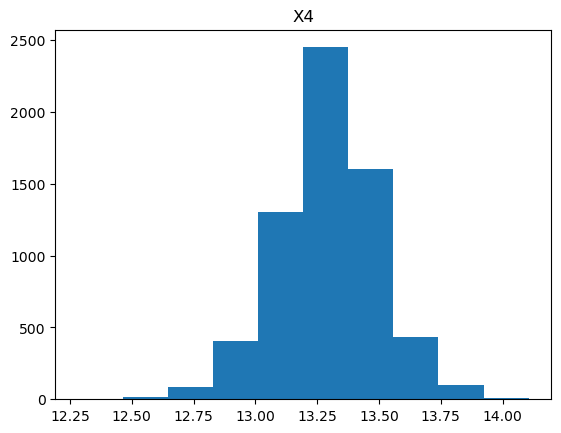

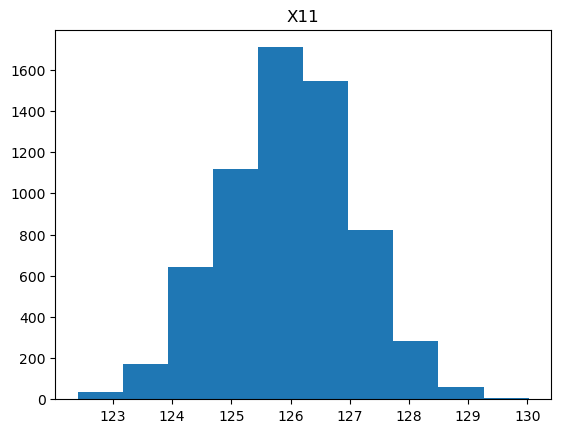

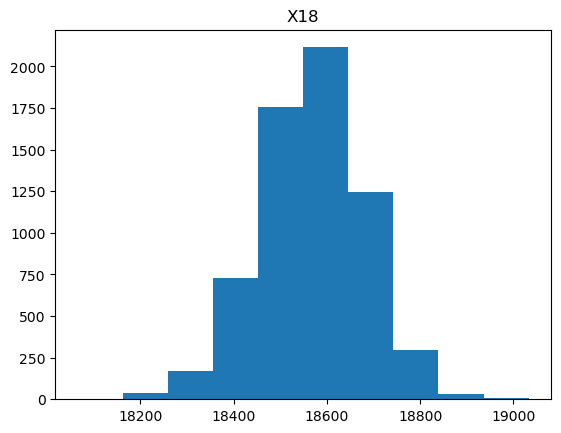

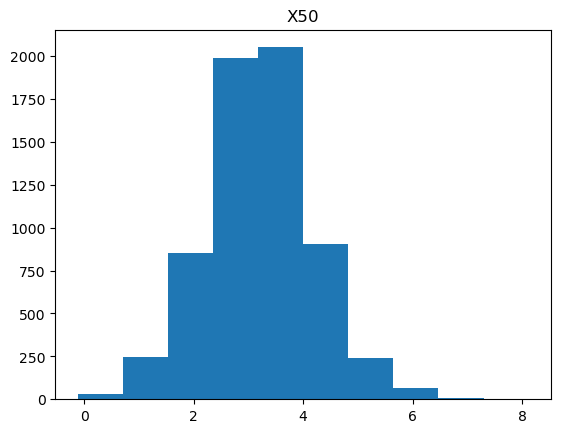

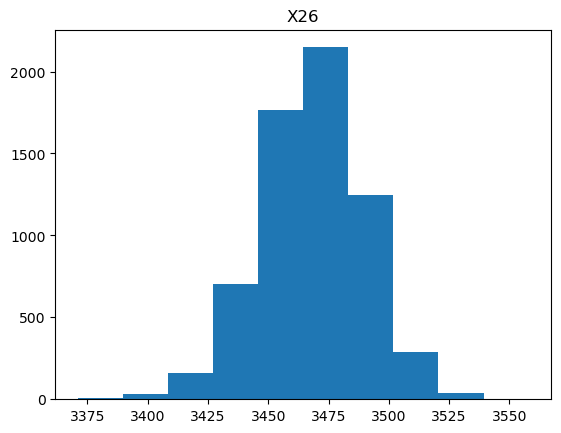

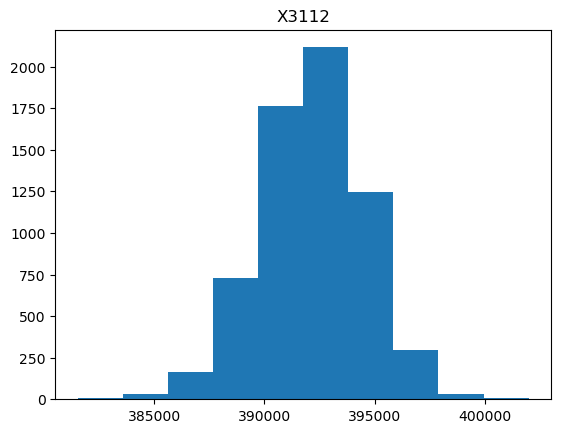

In [27]:
for k in final_df.columns[1:]:
    col = final_df[k]
    plt.title(k)
    plt.hist(col)
    plt.show()

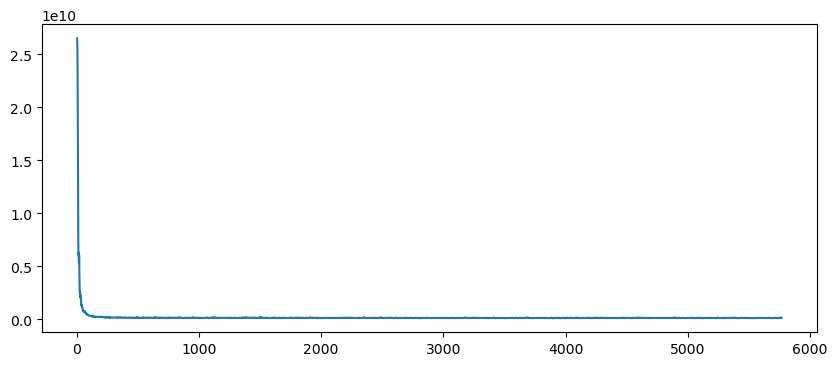

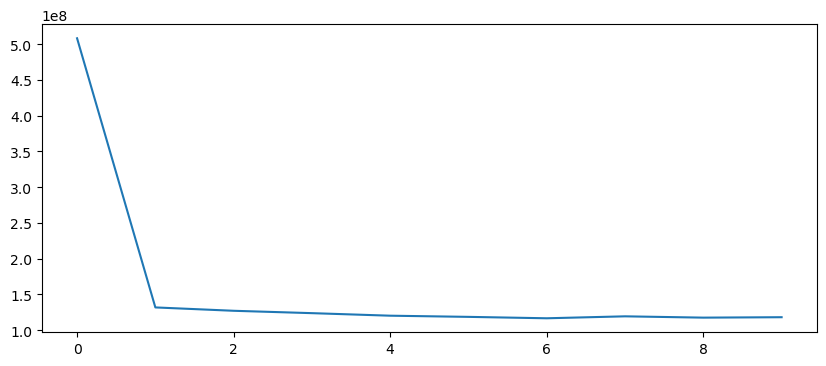

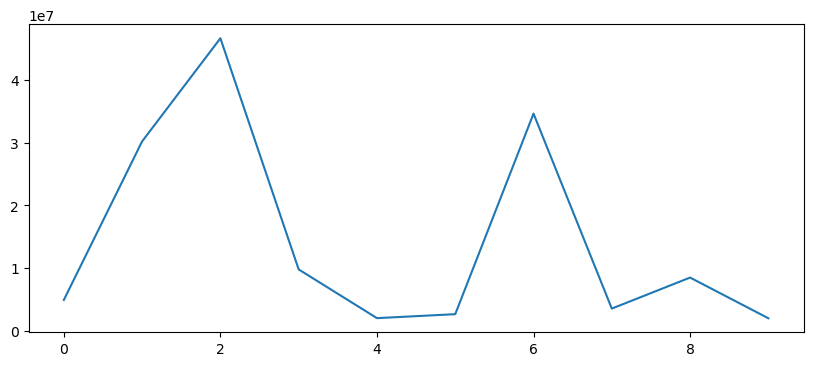

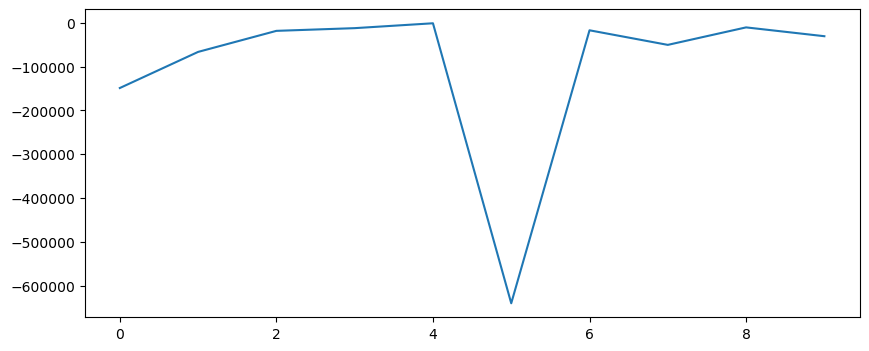

In [114]:
plt.figure(figsize=(10,4))
data_series = pd.Series(bk.batch_loss_list)
moving_average = data_series.rolling(window=5, center=False).mean()
plt.plot(moving_average, label='batch loss (mv avg 5)')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(bk.lists['epoch'], bk.lists['train_loss'])
plt.show()

plt.figure(figsize=(10,4))
plt.plot(bk.lists['epoch'], bk.lists['test_loss'])
plt.show()

plt.figure(figsize=(10,4))
plt.plot(bk.lists['epoch'], bk.lists['R2'])
plt.show()



